In [ ]:
# imports
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from collections import defaultdict

from tqdm import tqdm

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [ ]:
df_p = pd.read_csv("/content/drive/MyDrive/Multicore/parsec_dataset.csv")
df_s = pd.read_csv("/content/drive/MyDrive/Multicore/splash_dataset.csv")

del df_p['workload']
del df_s['name']
del df_s['size']
del df_p['size']
del df_s['single-thread-time']

df_p.rename(columns={'IPC': 'ipc', 'run_time': 'real-time', 'thread': 'threads'}, inplace=True)

In [ ]:
df = pd.concat([df_p, df_s], axis=0)
df.columns[:16]

Index(['ipc', 'branch-instructions', 'branch-misses', 'branch-miss-rate',
       'cache-misses', 'cache-miss-rate', 'cache-references', 'cycles',
       'instructions', 'cpu-clock', 'page-faults', 'L1-dcache-loads',
       'L1-icache-load-misses', 'LLC-load-misses', 'real-time', 'threads'],
      dtype='object')

In [ ]:
# filtering out single-thread records
df = df[df['threads'] != 1]

In [ ]:
# all features
# Either run this block or the block below this
# Run this block if you want to run with all features
X = df.loc[:, ['ipc', 'branch-instructions', 'branch-misses', 'branch-miss-rate',
       'cache-misses', 'cache-miss-rate', 'cache-references', 'cycles',
       'instructions', 'cpu-clock', 'page-faults', 'L1-dcache-loads',
       'L1-icache-load-misses', 'LLC-load-misses', 'threads']]

Y = df.loc[:, ['real-time']]

In [ ]:
# Run this block if you want to run with significant features only

# significant features
X = df.loc[:, ['cache-miss-rate', 'instructions', 'cpu-clock', 'page-faults',
       'L1-icache-load-misses', 'LLC-load-misses', 'threads']]

Y = df.loc[:, ['real-time']]

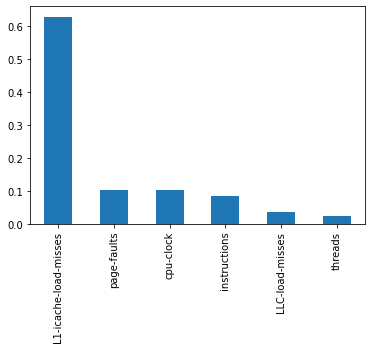

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X,Y['real-time'])

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='bar')


In [ ]:
'''
Writing one model for all 306 input points
'''

# scaling step
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
Y_scaled = Y.values
X_scaled.shape[0]

255

In [ ]:
# Collecting data for each model 
# Runs on selected features

# KFold Validation (10 folds)

actual_speedup = []
predicted_speedup = []
kf = KFold(n_splits=X_scaled.shape[0], shuffle=False)

results = defaultdict(lambda: defaultdict(list))


for train_index, test_index in tqdm(kf.split(X_scaled)):
  X_train, X_test = X_scaled[train_index], X_scaled[test_index]
  y_train, y_test = Y_scaled[train_index], Y_scaled[test_index]

  model = LinearRegression()
  model.fit(X_train, y_train.ravel())
  results['linear_regression']['predicted'] += model.predict(X_test).flatten().tolist()
  results['linear_regression']['actual'] += y_test.flatten().tolist()

  
  model = Lasso(random_state=42)
  model.set_params(alpha=0.01424539312472771)
  model.fit(X_train, y_train.ravel())
  results['lasso']['predicted'] += model.predict(X_test).flatten().tolist()
  results['lasso']['actual'] += y_test.flatten().tolist()

  model = Ridge(max_iter=10000, random_state=42)
  model.fit(X_train, y_train.ravel())
  results['ridge']['predicted'] += model.predict(X_test).flatten().tolist()
  results['ridge']['actual'] += y_test.flatten().tolist()
  
  model = SVR()
  model.fit(X_train, y_train.ravel())
  results['svr']['predicted'] += model.predict(X_test).flatten().tolist()
  results['svr']['actual'] += y_test.flatten().tolist()

  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train.ravel())
  results['decision_tree']['predicted'] += model.predict(X_test).flatten().tolist()
  results['decision_tree']['actual'] += y_test.flatten().tolist()
  
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train, y_train.ravel())
  results['random_forest']['predicted'] += model.predict(X_test).flatten().tolist()
  results['random_forest']['actual'] += y_test.flatten().tolist()

  model = AdaBoostRegressor(random_state=42)
  model.fit(X_train, y_train.ravel())
  results['ada_boost']['predicted'] += model.predict(X_test).flatten().tolist()
  results['ada_boost']['actual'] += y_test.flatten().tolist()

  model = GradientBoostingRegressor(random_state=42)
  model.fit(X_train, y_train.ravel())
  results['gradient_boost']['predicted'] += model.predict(X_test).flatten().tolist()
  results['gradient_boost']['actual'] += y_test.flatten().tolist()

  kernel = DotProduct() + WhiteKernel()
  model = GaussianProcessRegressor(kernel=kernel, random_state=42)
  model.fit(X_train, y_train.ravel())
  results['gaussian_regression']['predicted'] += model.predict(X_test).flatten().tolist()
  results['gaussian_regression']['actual'] += y_test.flatten().tolist()

for model in results:
  results[model]['mse'] = mean_squared_error(y_true=results[model]['actual'], y_pred=results[model]['predicted'])
  results[model]['mae'] = mean_absolute_error(y_true=results[model]['actual'], y_pred=results[model]['predicted'])
  results[model]['r2score'] = r2_score(y_true=results[model]['actual'], y_pred=results[model]['predicted'])
  results[model]['adj_r2score'] = 1 - ((1 - results[model]['r2score']) * (len(results[model]['actual']) - 1) / (len(results[model]['actual']) - 1 - X_train.shape[1]))
  print(model, ' '*(20-len(model)), results[model]['mse'], '\t', results[model]['mae'], '\t', results[model]['r2score'], '\t', results[model]['adj_r2score'] )

255it [02:29,  1.71it/s]

linear_regression     2.0834474060048604 	 0.9361050676448867 	 0.6484409523103745 	 0.6384777404325308
lasso                 2.0514717635951727 	 0.953936730397768 	 0.6538364935476595 	 0.6440261917453665
ridge                 2.0797635561851986 	 0.9445771595862508 	 0.6490625618267458 	 0.6391169664129289
svr                   1.1628892536466784 	 0.618195693454194 	 0.803775109752124 	 0.798214080473844
decision_tree         0.4189232586666667 	 0.29676705882352944 	 0.9293112648548689 	 0.9273079403770716
random_forest         0.4537882062808318 	 0.2935030980392158 	 0.9234281848473499 	 0.9212581334057768
ada_boost             0.7988814355571003 	 0.7037015717056012 	 0.8651974626804091 	 0.8613771478575867
gradient_boost        0.3396591525033264 	 0.27589373708898807 	 0.9426862190766259 	 0.9410619418844655
gaussian_regression   2.080708759853417 	 0.9520419488862377 	 0.6489030690070501 	 0.6389529535538085


In [ ]:
# Simple Split of train and test data

seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=test_size, random_state=seed)

actual_speedup = []
predicted_speedup = []

results = defaultdict(lambda: defaultdict(list))

model = LinearRegression()
model.fit(X_train, y_train)
results['linear_regression']['predicted'] = model.predict(X_test).flatten().tolist()
results['linear_regression']['actual'] = y_test.flatten().tolist()

model = Lasso(random_state=42)
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train.ravel())
model.set_params(alpha=lassocv.alpha_)
model.fit(X_train, y_train.ravel())
results['lasso']['predicted'] += model.predict(X_test).flatten().tolist()
results['lasso']['actual'] += y_test.flatten().tolist()

model = Ridge(max_iter=10000, random_state=42)
model.fit(X_train, y_train)
results['ridge']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['ridge']['actual'] = (y_test).flatten().tolist()

model = SVR()
model.fit(X_train, y_train)
results['svr']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['svr']['actual'] = (y_test).flatten().tolist()

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
results['decision_tree']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['decision_tree']['actual'] = (y_test).flatten().tolist()

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
results['random_forest']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['random_forest']['actual'] = (y_test).flatten().tolist()

model = AdaBoostRegressor(random_state=42)
model.fit(X_train, y_train)
results['ada_boost']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['ada_boost']['actual'] = (y_test).flatten().tolist()

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
results['gradient_boost']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['gradient_boost']['actual'] = (y_test).flatten().tolist()

kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)
model.fit(X_train, y_train)
results['gaussian_regression']['predicted'] = (model.predict(X_test)).flatten().tolist()
results['gaussian_regression']['actual'] = (y_test).flatten().tolist()

# NN_model = Sequential()
# NN_model.add(Dense(15, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
# NN_model.add(Dense(10, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(15, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(10, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
# NN_model.compile(loss='mean_squared_error', optimizer='adam')
# NN_model.summary()
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]
# NN_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
# predictions = NN_model.predict(X_test)
# results['ann']['predicted'] = predictions.flatten().tolist()
# results['ann']['actual'] = y_test.flatten().tolist()


for model in results:
  results[model]['mse'] = mean_squared_error(results[model]['actual'], results[model]['predicted'], squared=True)
  results[model]['mae'] = mean_absolute_error(y_true=results[model]['actual'], y_pred=results[model]['predicted'])
  results[model]['r2score'] = r2_score(y_true=results[model]['actual'], y_pred=results[model]['predicted'])
  results[model]['adj_r2score'] = 1 - ((1 - results[model]['r2score']) * (len(results[model]['actual']) - 1) / (len(results[model]['actual']) - 1 - X_train.shape[1]))
  print(model, ' '*(20-len(model)), results[model]['mse'], '\t', results[model]['mae'], '\t', results[model]['r2score'], '\t', results[model]['adj_r2score'] )

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


linear_regression     2.0764080430767557 	 0.961952625323083 	 0.6418609548399641 	 0.6055280082295257
lasso                 2.091098773219642 	 0.9691716859237433 	 0.6393270963897334 	 0.6027370916756484
ridge                 2.0955083486295383 	 0.9688540210954449 	 0.6385665324282679 	 0.6018993690514255
svr                   1.7276982935077374 	 0.7365090890851519 	 0.7020064436638229 	 0.6717752133108774
decision_tree         0.2918289148051948 	 0.23552987012987012 	 0.9496653226484548 	 0.9445589061055445
random_forest         0.35864652745142855 	 0.2730282077922077 	 0.9381406148373944 	 0.9318650250382895
ada_boost             0.6825245287584956 	 0.6737319435212124 	 0.882278108176816 	 0.8703353075570727
gradient_boost        0.20867734227209722 	 0.21284770902273173 	 0.9640073133230971 	 0.9603558813413823
gaussian_regression   2.117408075741973 	 0.9757013759606077 	 0.634789265535345 	 0.5977389011693655


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
